# JPEG compression

Reference: https://en.wikipedia.org/wiki/JPEG

## DTC encoder

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e06f6ee04c9c879a283edcbb7b1fc18b86fcec5b)

Where,

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8f4e45f93406b25c18d6e1ad2359229516b2dd4f)

## DTC decoder

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/b57a66586a29b5d371243341173f5fd1c00822b9)

## Flow

![](https://www.researchgate.net/profile/Thawar_Alnasiri/publication/267838912/figure/fig1/AS:393053832531971@1470722744744/JPEG-Compression-Algorithm.png)

### 1) Getting image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sys.path.append("../")

from dct.transformation import dct_encode, dct_decode
from dct.quantization import get_quantization_matrix

from tqdm import tqdm 

In [2]:
img = cv2.imread("../image/sample.jpeg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert color image to gray image

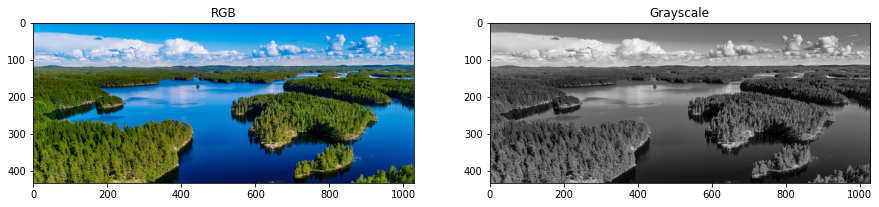

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title(f"RGB")

ax[-1].imshow(img_gray, cmap="gray")
ax[-1].set_title("Grayscale")

plt.show()

### 2) Apply DCT for each chunk

Original JPEG algorithm, they used chunk size = 8. For each chunk, we will apply dct to transform image from spatial domain to frequency domain.

In [4]:
# resize for easier to compress
shape = img_gray.shape
img_gray = img_gray[:shape[0] - shape[0]%8, :shape[-1] - shape[-1]%8]
shape = img_gray.shape

In [5]:
res = []
with tqdm(total=shape[0]//8 * shape[-1]//8, position=0, leave=True) as pbar:
    for i in range(0, shape[0], 8):
        for j in range(0, shape[-1], 8):
            img_slide = img_gray.copy()[i: i+8, j: j+8]
            img_centered = img_slide - 128  # we should normalize image with range -127 to 128
            img_dct = dct_encode(img_centered)
            res.append(img_dct)
            pbar.update()

100%|██████████| 6912/6912 [01:51<00:00, 62.26it/s]


### 3) Apply quantization

In this section, the result will become to lossy.

In [6]:
quality = 30

Q = get_quantization_matrix(quality)
Q

array([[ 27.,  18.,  17.,  27.,  40.,  67.,  85., 102.],
       [ 20.,  20.,  23.,  32.,  43.,  97., 100.,  92.],
       [ 23.,  22.,  27.,  40.,  67.,  95., 115.,  93.],
       [ 23.,  28.,  37.,  48.,  85., 145., 133., 103.],
       [ 30.,  37.,  62.,  93., 113., 182., 172., 128.],
       [ 40.,  58.,  92., 107., 135., 173., 188., 153.],
       [ 82., 107., 130., 145., 172., 202., 200., 168.],
       [120., 153., 158., 163., 187., 167., 172., 165.]])

In [7]:
res2 = []
with tqdm(total=len(res), position=0, leave=True) as pbar:
    for chunk in res:
        img_a_q = np.round(chunk / Q)
        res2.append(img_a_q)
        pbar.update()

100%|██████████| 6912/6912 [00:00<00:00, 97469.15it/s]


### 4) Apply entropy encoder 

TODO

### 5) De-quantization

In [8]:
res3 = []
with tqdm(total=len(res2), position=0, leave=True) as pbar:
    for chunk in res2:
        img_a_q = chunk * Q
        res3.append(img_a_q)
        pbar.update()

100%|██████████| 6912/6912 [00:00<00:00, 389407.91it/s]


### 6) Apply Inverse DCT

In [9]:
res4 = []
with tqdm(total=len(res3), position=0, leave=True) as pbar:
    for chunk in res3:
        img_idct = dct_decode(chunk)
        res4.append(img_idct)
        pbar.update()

100%|██████████| 6912/6912 [00:47<00:00, 144.96it/s]


### 7) Combine all chunks

In [10]:
rec_img = np.zeros(shape, dtype=np.uint8)
idx = 0

with tqdm(total=shape[0]//8 * shape[-1]//8, position=0, leave=True) as pbar:
    for i in range(0, shape[0], 8):
        for j in range(0, shape[-1], 8):
            rec_img[i: i+8, j: j+8] = (res4[idx] + 128).astype(np.uint8)
            pbar.update()
            idx += 1

100%|██████████| 6912/6912 [00:00<00:00, 178184.84it/s]


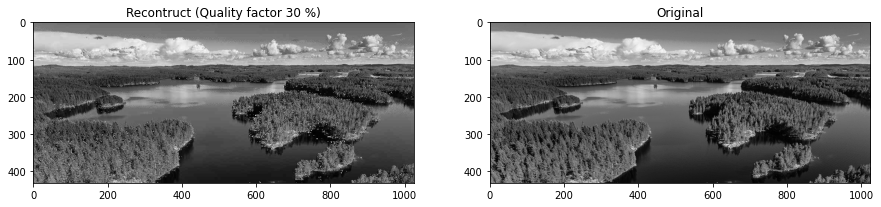

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax[0].imshow(rec_img, cmap="gray")
ax[0].set_title(f"Recontruct (Quality factor {quality} %)")

ax[-1].imshow(img_gray, cmap="gray")
ax[-1].set_title("Original")

plt.show()